<h1><span style="color: #000000; background-color: #ffffff;">Import Necessary Libraries</span></h1>

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
from datetime import datetime, timedelta
from statistics import mean
import numpy as np
import darts
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller

from dateutil.tz import tzutc
from dateutil.parser import parse

def date_utc(s):
    return parse(s, tzinfos=tzutc)

In [7]:
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel, NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics import mape, r2_score,mae
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.models import TCNModel

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

<h1><span style="background-color: #ffffff; color: #000000;">Read the CSV file and resample the data</span></h1>

In [52]:
df = pd.read_csv('Raspberry/anujrachel/netmeter.csv',
                 sep = ';',usecols = ["Date","Valeur"], parse_dates =["Date"], index_col ="Date")
power = pd.DataFrame()
power["power"] = df.resample('1H').mean().interpolate()

power["date"] = power.index
power

,power,date
Date,,
2022-01-01 00:00:00,278.866667,2022-01-01 00:00:00
2022-01-01 01:00:00,228.375000,2022-01-01 01:00:00
2022-01-01 02:00:00,260.225000,2022-01-01 02:00:00
2022-01-01 03:00:00,222.072222,2022-01-01 03:00:00
2022-01-01 04:00:00,259.430556,2022-01-01 04:00:00
...,...,...
2022-12-30 19:00:00,430.924901,2022-12-30 19:00:00
2022-12-30 20:00:00,371.473310,2022-12-30 20:00:00
2022-12-30 21:00:00,302.598007,2022-12-30 21:00:00


<h1><span style="color: #000000; background-color: #ffffff;">Normalise and plot the data</span></h1>

Text(0.5, 1.0, 'Hourly electricity consumption')

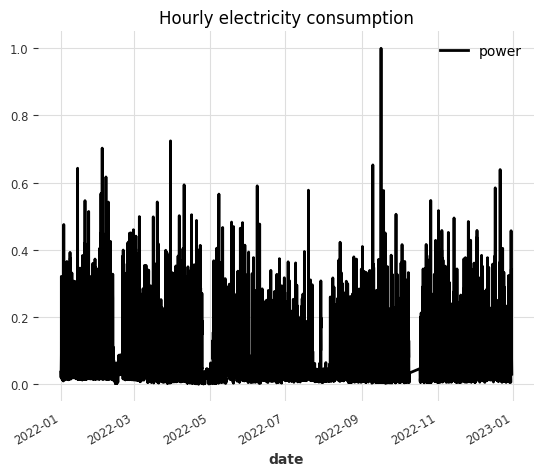

In [14]:
from darts import TimeSeries
series = TimeSeries.from_dataframe(power, 'date', 'power')
transformer = Scaler()
series_transformed = transformer.fit_transform(series)
series_transformed.plot()
plt.title("Hourly electricity consumption")

<h1><span style="color: #000000; background-color: #ffffff;">Time Series Decomposition</span></h1>

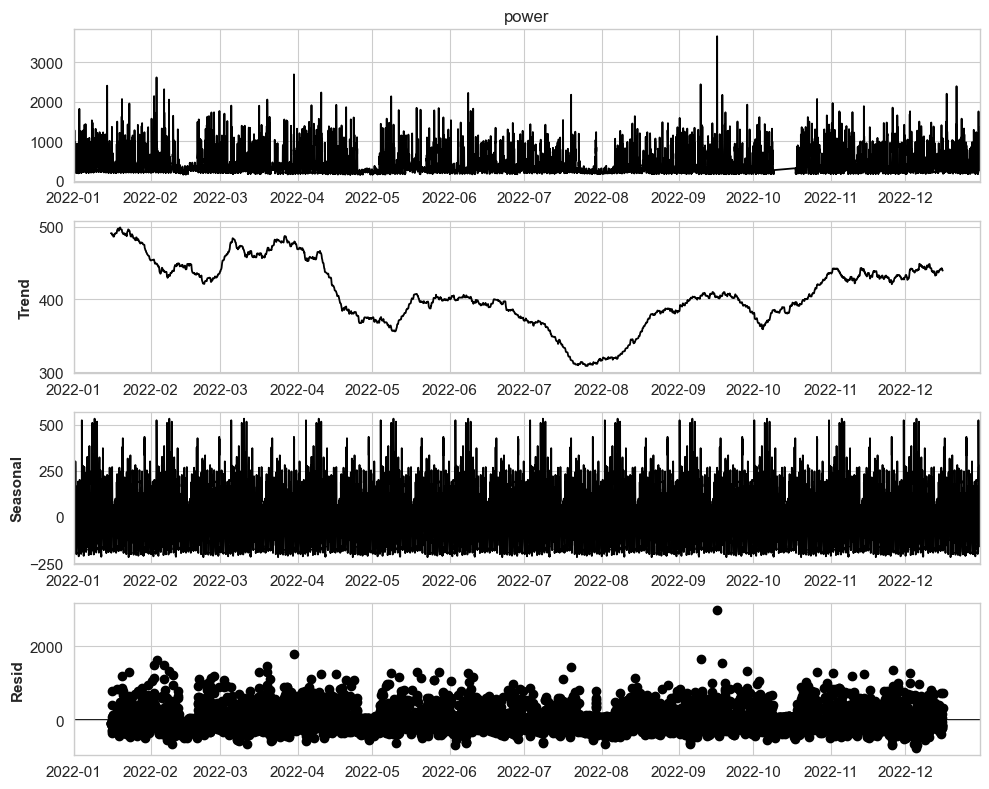

In [49]:
import statsmodels.api as sm
from matplotlib import rcParams

import seaborn as sns 
%matplotlib inline 
sns.set_style("whitegrid")
plt.rc('xtick', labelsize=11) 
plt.rc('ytick', labelsize=11) 


rcParams['figure.figsize'] = 10, 8
rcParams['axes.labelsize'] = 11
rcParams['ytick.labelsize'] = 11
rcParams['xtick.labelsize'] = 11
decomposition = sm.tsa.seasonal_decompose(power["power"], model='additive', period = 24*30 )
decomp = decomposition.plot()
#decomp.suptitle('Electricity consumption decomposition', fontsize=20, family = "simsun")


<h1><span style="color: #000000; background-color: #ffffff;">Statistical Analysis</span></h1>

In [50]:
power["power"].describe()

count    8736.000000
mean      412.358355
std       305.836092
min       151.689498
25%       222.337282
50%       294.822410
75%       446.785882
max      3659.466292
Name: power, dtype: float64

<h1 class="elementor-heading-title elementor-size-default" style="box-sizing: border-box; border: 0px; font-size: 29px; margin: 0px; outline: 0px; padding: 0px; vertical-align: baseline; clear: both; color: #051e50; line-height: 1; font-family: roboto, inter, 'system-ui'; background-color: #ffffff;"><span style="color: #000000; background-color: #ffffff;">Augmented Dickey Fuller Test</span></h1>

In [51]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(power["power"], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')    

ADF Statistic: -12.381377474071506
n_lags: 5.020178865912697e-23
p-value: 5.020178865912697e-23
Critial Values:
   1%, -3.4311010883544237
Critial Values:
   5%, -2.8618719309555227
Critial Values:
   10%, -2.5669466818853945
